# Kinetic Energy

Mean and Eddy Kinetic Energy Decomposition 

## Theory

For a hydrostatic ocean like MOM5, the relevant kinetic energy per mass is 

$$ KE = \frac{1}{2} (u^2 + v^2).$$

The vertical velocity component, $w$, does not appear in the mechanical energy budget. It is very much subdominant. But more fundamentally, it simply does not appear in the mechanical energy buget for a hydrostatic ocean. 

For a non-steady fluid, we can define the time-averaged kinetic energy as the __total kinetic energy__, TKE

$$ TKE = \left< K \right > = \frac{1}{T} \int_0^T \frac{1}{2} \left( u^2 + v^2 \right) dt $$

It is useful to decompose the velocity in the mean and time varying components

$$ u = \bar{u} + u'$$

The __mean kinetic energy__ is the energy associated with the mean flow

$$ MKE = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right) $$

The kinetic energy of the time varying component is the __eddy kinetic energy__, EKE. This quantity can be obtained by 
substracting the velocity means and calculating the kinetic energy of the 
perturbation velocity quantities.

$$ EKE =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] } $$
                                 
MKE and EKE partition the total kinetic energy

$$TKE = EKE + MKE $$


## Calculation


We start by importing some useful packages.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc

from cosima_cookbook import distributed as ccd

import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import xarray as xr

from dask.distributed import Client

In [2]:
from tqdm import tqdm_notebook

Import cartopy to plot maps:

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as feature

land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.2)

Start up a dask cluster.

In [4]:
client = Client(n_workers=20)
client

<Client: 'tcp://127.0.0.1:46055' processes=20 threads=40, memory=103.08 GB>

Create a database session and select an experiment. Here we choose an experiment which has daily velocities saved for the Southern Ocean.

In [5]:
session = cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

While not difficult to write down, this is fairly involved computation since to compute the eddy kinetic energy requires both the velocity and the mean of the velocity components.  Since the dataset is large, we want to avoid loading all of the velocity data into memory at the same time.

To calculate EKE, we need horizontal velocities $u$ and $v$, preferably saved at `1 daily` frequency (or perhaps `5 daily`). You can check whether your experiment has that kind of data:

In [6]:
varlist = cc.querying.get_variables(session, expt,frequency = '1 daily')
varlist

name frequency  \
0              average_DT   1 daily   
1              average_T1   1 daily   
2              average_T2   1 daily   
3                   eta_t   1 daily   
4         frazil_3d_int_z   1 daily   
5                     mld   1 daily   
6                      nv   1 daily   
7               pme_river   1 daily   
8                    salt   1 daily   
9       sfc_hflux_coupler   1 daily   
10  sfc_hflux_from_runoff   1 daily   
11          sfc_hflux_pme   1 daily   
12         st_edges_ocean   1 daily   
13               st_ocean   1 daily   
14           surface_salt   1 daily   
15           surface_temp   1 daily   
16         sw_edges_ocean   1 daily   
17               sw_ocean   1 daily   
18                   temp   1 daily   
19                   time   1 daily   
20            time_bounds   1 daily   
21                      u   1 daily   
22               uhrho_et   1 daily   
23                      v   1 daily   
24               vhrho_nt   1 daily   
25                     wt   1 daily   
26               xt_ocean   1 daily   
27               xu_ocean   1 daily   
28               yt_ocean   1 daily   
29               yu_ocean   1 daily   

                                           ncfile  # ncfiles  \
0                  output675/ocean/ocean_daily.nc        481   
1                  output675/ocean/ocean_daily.nc        481   
2                  output675/ocean/ocean_daily.nc        481   
3                  output675/ocean/ocean_daily.nc        479   
4                  output675/ocean/ocean_daily.nc        454   
5                  output675/ocean/ocean_daily.nc        479   
6                  output675/ocean/ocean_daily.nc        481   
7                  output675/ocean/ocean_daily.nc        454   
8       output279/ocean/ocean_daily_3d_salt_12.nc        252   
9                  output675/ocean/ocean_daily.nc        454   
10                 output675/ocean/ocean_daily.nc        454   
11                 output675/ocean/ocean_daily.nc        454   
12         output260/ocean/ocean_daily_3d_temp.nc          1   
13      output279/ocean/ocean_daily_3d_salt_12.nc       1056   
14                 output675/ocean/ocean_daily.nc        454   
15                 output675/ocean/ocean_daily.nc        479   
16           output260/ocean/ocean_daily_3d_wt.nc          1   
17        output279/ocean/ocean_daily_3d_wt_12.nc        250   
18      output279/ocean/ocean_daily_3d_temp_12.nc        252   
19                 output675/ocean/ocean_daily.nc       1785   
20                 output675/ocean/ocean_daily.nc       1785   
21         output279/ocean/ocean_daily_3d_u_12.nc        252   
22  output279/ocean/ocean_daily_3d_uhrho_et_12.nc         24   
23         output279/ocean/ocean_daily_3d_v_12.nc        252   
24  output279/ocean/ocean_daily_3d_vhrho_nt_12.nc         24   
25        output279/ocean/ocean_daily_3d_wt_12.nc        250   
26                 output675/ocean/ocean_daily.nc       1281   
27         output279/ocean/ocean_daily_3d_v_12.nc        504   
28                 output675/ocean/ocean_daily.nc       1281   
29         output279/ocean/ocean_daily_3d_v_12.nc        504   

             time_start             time_end  
0   1950-01-01 00:00:00  2070-01-01 00:00:00  
1   1950-01-01 00:00:00  2070-01-01 00:00:00  
2   1950-01-01 00:00:00  2070-01-01 00:00:00  
3   1950-01-01 00:00:00  2070-01-01 00:00:00  
4   1956-04-01 00:00:00  2070-01-01 00:00:00  
5   1950-01-01 00:00:00  2070-01-01 00:00:00  
6   1950-01-01 00:00:00  2070-01-01 00:00:00  
7   1956-04-01 00:00:00  2070-01-01 00:00:00  
8   1950-01-01 00:00:00  1971-01-01 00:00:00  
9   1956-04-01 00:00:00  2070-01-01 00:00:00  
10  1956-04-01 00:00:00  2070-01-01 00:00:00  
11  1956-04-01 00:00:00  2070-01-01 00:00:00  
12  1966-01-01 00:00:00  1966-04-01 00:00:00  
13  1950-01-01 00:00:00  1971-01-01 00:00:00  
14  1956-04-01 00:00:00  2070-01-01 00:00:00  
15  1950-01-01 00:00:00  2070-01-01 00:00:00  
16  1966-01-01 00:00:00  19

### Example

For example, let's calculate the mean and eddy kinetic energy over the last year of this particular model run:

In [7]:
start_time = '1970-01-01'

Here we build datasets for the variables u and v

In [8]:
u = cc.querying.getvar(expt, 'u', session, ncfile='ocean_daily_3d_u_%.nc', start_time = start_time)
v = cc.querying.getvar(expt, 'v', session, ncfile='ocean_daily_3d_v_%.nc', start_time = start_time)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_u_07.nc', 'ocean_daily_3d_u_11.nc', 'ocean_daily_3d_u_12.nc', 'ocean_daily_3d_u_09.nc', 'ocean_daily_3d_u_04.nc', 'ocean_daily_3d_u_01.nc', 'ocean_daily_3d_u_08.nc', 'ocean_daily_3d_u_10.nc', 'ocean_daily_3d_u_03.nc', 'ocean_daily_3d_u_05.nc', 'ocean_daily_3d_u_06.nc', 'ocean_daily_3d_u_02.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_v_03.nc', 'ocean_daily_3d_v_11.nc', 'ocean_daily_3d_v_12.nc', 'ocean_daily_3d_v_06.nc', 'ocean_daily_

The kinetic energy is given by

$$ KE = \frac{1}{2} (u^2 + v^2)$$

we construct the following expression:

In [9]:
KE = 0.5*(u**2 + v**2)

You may notice that this line takes only a moment to run. The calculation is not (yet) being run. Rather, XArray needs to broadcast the squares of the velocity fields together to determine the final shape of KE. 

This is too large to store locally.  We need to reduce the data in some way.  

The mean kinetic energy is calculated by this function, which returns the depth integrated KE:

$$ \int_{z_0}^{z} KE dz$$

In [10]:
dz = np.gradient(KE.st_ocean)[:, np.newaxis, np.newaxis]
KE_dz = KE*dz

MKE = KE_dz.mean('time').sum('st_ocean')

In [11]:
#MKE.compute()

`MKE.compute()` or any loading of the data is extremely unreliable, due to the number of tasks and memory required to load the dataset. Moreover, it will commonly restart the workers after the loading hits the memory bound. Therefore, in order to analyse the data, it's fundamental to compute it by chunks. This is allowed by the function `compute_by_block` in the Cosima-Cookbook framework or by using dask, to specify the chunk size. 

Now using the CC framework:

`compute_by_blocks` computes the corresponding calculation for each chunk.

In [25]:
import dask.array as dsa
data = dsa.random.random((20, 20, 5), chunks=(10, 10, 5))
display(data)

y=1/2*(data**2+data**2)

dask.array<random_sample, shape=(20, 20, 5), dtype=float64, chunksize=(10, 10, 5), chunktype=numpy.ndarray>

The example data shown above has four chunks, when xarray executes, it loads in parallel all the corresponding chunks using all the available memory (following figure). However, when `compute_by_blocks` is executed, it only alocates memory for the final result, and evaluates each individual chunk one at the time (It loops for each of the computations of the figure bellow). Therefore, it performs excellent with large datasets.

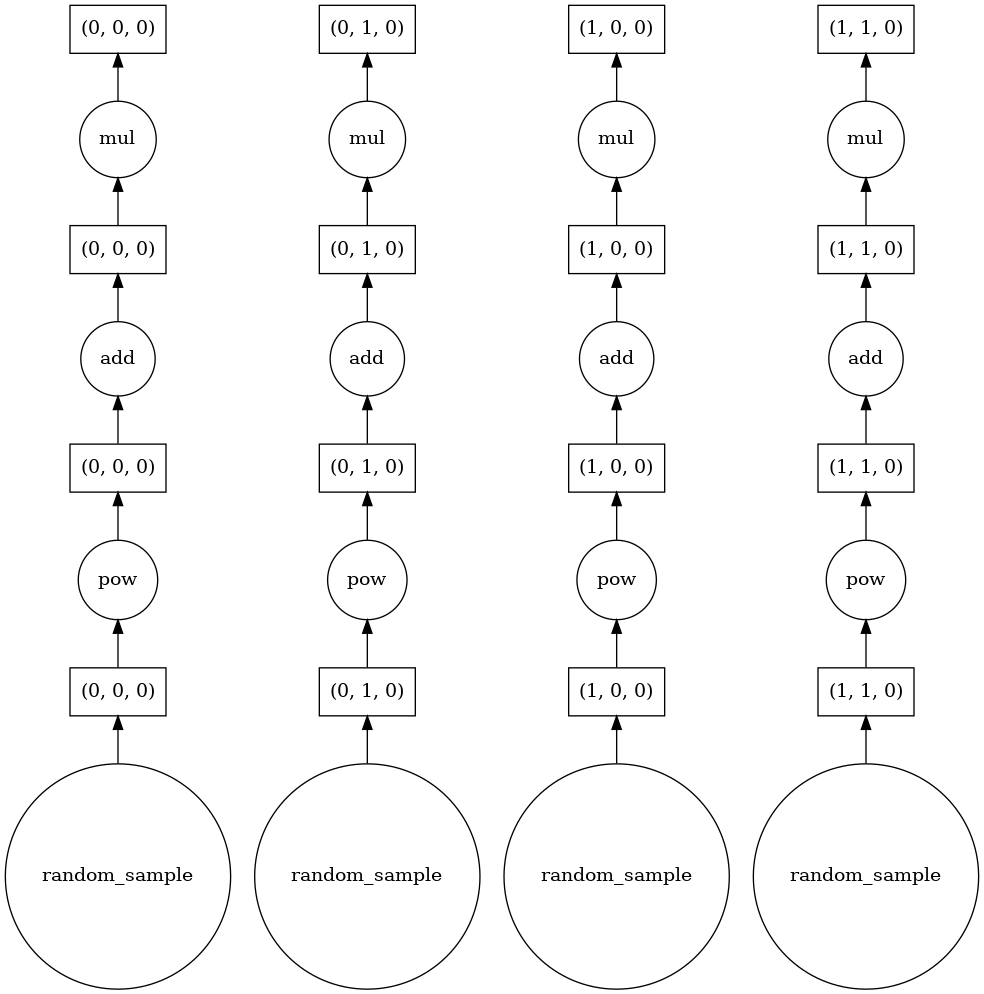

In [28]:
y.visualize()

In [12]:
%%time
MKE_v3 = ccd.compute_by_block(MKE)

CPU times: user 9min 57s, sys: 30.7 s, total: 10min 28s
Wall time: 15min 5s


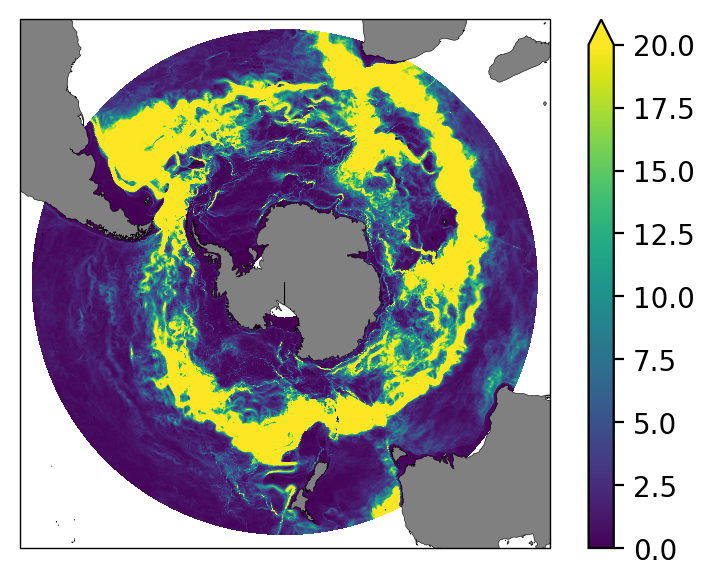

In [13]:
fig = plt.figure(figsize=(5, 3.5), dpi=100)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

MKE_v3.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=20)

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)

Snapshot plot of depth integrated KE for 1970-12-01. As shown here, the conventional method of computing directly from the dataset only works in small slices of data (ie. snapshots up to a couple of weeks).

In [14]:
fig = plt.figure(figsize=(5, 3.5), dpi=100)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

KE_dz.isel(time=0).sum('st_ocean').plot(vmax=20, transform=ccrs.PlateCarree());

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)

## Mean Kinetic Energy

For the mean kinetic energy, we need to average the velocities over time over time.

$$ MKE = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right) $$

In [15]:
u_mean = u.mean('time')
v_mean = v.mean('time')

In [16]:
MKE = (0.5*(u_mean**2 + v_mean**2)*dz).sum('st_ocean')

In [17]:
%%time
MKE = ccd.compute_by_block(MKE)

CPU times: user 8min 42s, sys: 23.7 s, total: 9min 6s
Wall time: 12min 32s


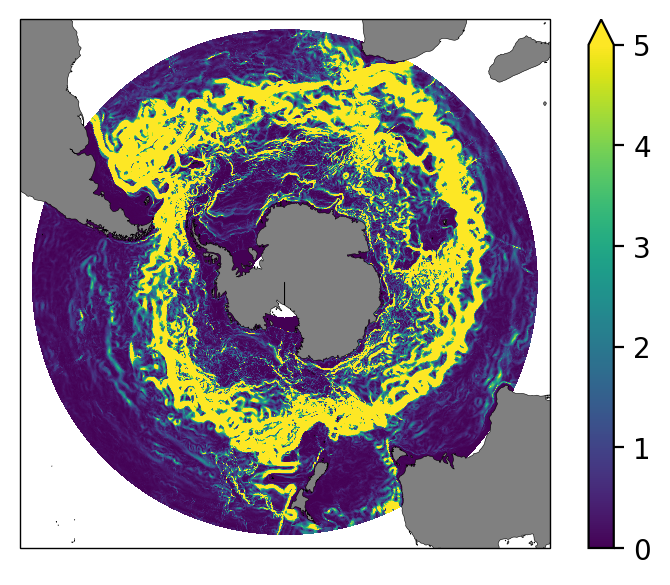

In [18]:
fig = plt.figure(figsize=(5, 3.5),dpi=100)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

MKE.plot(ax=ax,transform=ccrs.PlateCarree(), vmax=5);

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)

## Eddy Kinetic Energy

We calculate the perturbation velocities


$$ EKE =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] } $$

In [19]:
u_transient = u - u_mean
v_transient = v - v_mean

In [20]:
EKE = (0.5*(u_transient**2 + v_transient**2)*dz).mean('time').sum('st_ocean')

In [21]:
%%time
EKE = ccd.compute_by_block(EKE)

CPU times: user 21min 34s, sys: 1min 23s, total: 22min 57s
Wall time: 41min 30s


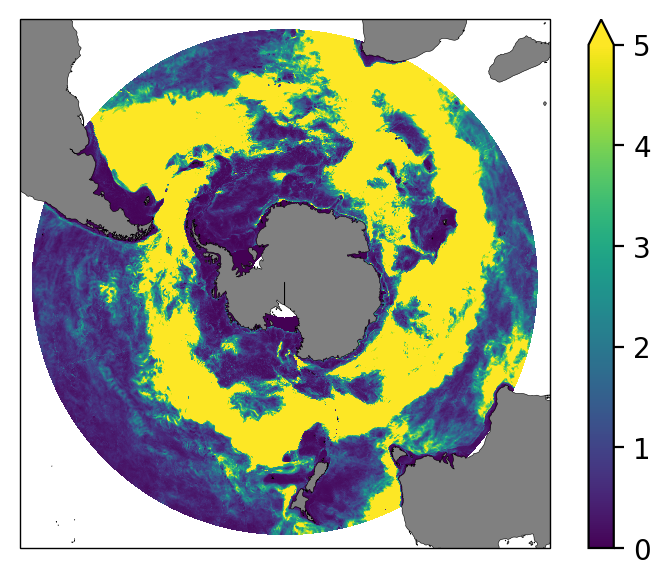

In [22]:
fig = plt.figure(figsize=(5, 3.5),dpi=100)

ax = fig.add_subplot(1, 1, 1, projection= ccrs.SouthPolarStereo())

EKE.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=5);

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)

# Functions using the CC framework and dask.
(Functions of previously described code)

In [10]:
from joblib import Memory

memory = Memory(cachedir='/g/data/v45/cosima-cookbook/', verbose=0)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/g/data/v45/cosima-cookbook/'", use "location='/g/data/v45/cosima-cookbook/'" instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
from cosima_cookbook.netcdf_index import get_nc_variable

Here are functions for calculating both MKE and EKE using `Cosima-Cookbook`.

In [25]:
@memory.cache
def calc_mke(expt, n=6, start_time='2000-01-01'):
    
    print('Opening datasets...')
    u = cc.querying.getvar(expt, 'u', session, ncfile='ocean_daily_3d_u_%.nc', start_time=start_time)
    v = cc.querying.getvar(expt, 'v', session, ncfile='ocean_daily_3d_v_%.nc', start_time=start_time)
    
    print('Preparing computation...')
    u_mean = u.mean('time')
    v_mean = v.mean('time')
    dz = np.gradient(KE.st_ocean)[:, np.newaxis, np.newaxis]

    MKE_cc = (0.5*(u_mean**2 + v_mean**2)*dz).sum('st_ocean')
    
    print('Calculating...')
    MKE_result = ccd.compute_by_block(MKE_cc)
    
    return MKE_result

In [26]:
%%time
MKE_cc = calc_mke(expt, n=24, start_time=start_time)

Opening datasets...


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_u_04.nc', 'ocean_daily_3d_u_10.nc', 'ocean_daily_3d_u_01.nc', 'ocean_daily_3d_u_11.nc', 'ocean_daily_3d_u_05.nc', 'ocean_daily_3d_u_06.nc', 'ocean_daily_3d_u_03.nc', 'ocean_daily_3d_u_07.nc', 'ocean_daily_3d_u_08.nc', 'ocean_daily_3d_u_12.nc', 'ocean_daily_3d_u_09.nc', 'ocean_daily_3d_u_02.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_v_05.nc', 'ocean_daily_3d_v_08.nc', 'ocean_daily_3d_v_02.nc', 'ocean_daily_3d_v_09.nc', 'ocean_daily_

Preparing computation...
Calculating...


CPU times: user 9min 59s, sys: 33 s, total: 10min 32s
Wall time: 14min 23s


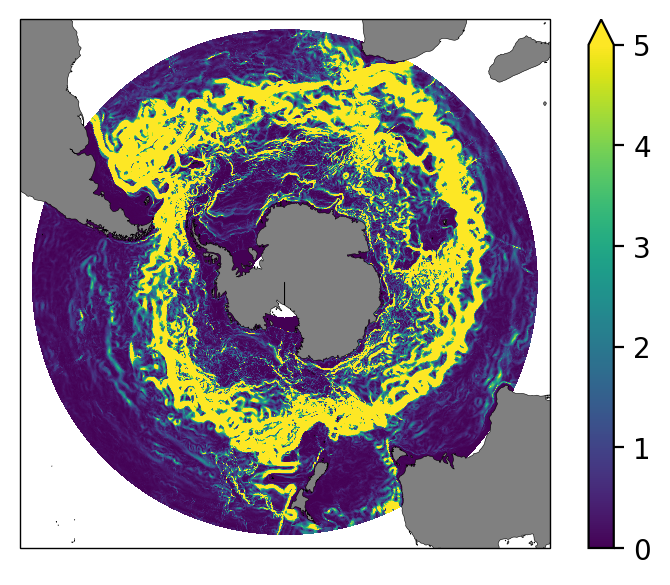

In [27]:
fig = plt.figure(figsize=(5, 3.5), dpi=100)

ax = fig.add_subplot(1, 1, 1, projection= ccrs.SouthPolarStereo())

MKE_cc.plot(ax=ax, transform=ccrs.PlateCarree(),vmax=5);

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)

In [28]:
@memory.cache
def calc_eke(expt, n=6, start_time='2000-01-01'):
    
    print('Opening datasets...')
    u = cc.querying.getvar(expt, 'u', session, ncfile='ocean_daily_3d_u_%.nc', start_time=start_time)
    v = cc.querying.getvar(expt, 'v', session, ncfile='ocean_daily_3d_v_%.nc', start_time=start_time)
    
    print('Preparing computation...')
    u_mean = u.mean('time')
    v_mean = v.mean('time')
    
    dz = np.gradient(KE.st_ocean)[:, np.newaxis, np.newaxis]
    
    u_transient = u - u_mean
    v_transient = v - v_mean
    EKE_cc = (0.5*(u_transient**2 + v_transient**2)*dz).mean('time').sum('st_ocean')

    print('Calculating...')
    EKE_result = ccd.compute_by_block(EKE_cc)
    
    return EKE_result

In [29]:
%%time
EKE_cc = calc_eke(expt, n=24, start_time=start_time)

Opening datasets...


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_u_04.nc', 'ocean_daily_3d_u_10.nc', 'ocean_daily_3d_u_01.nc', 'ocean_daily_3d_u_11.nc', 'ocean_daily_3d_u_05.nc', 'ocean_daily_3d_u_06.nc', 'ocean_daily_3d_u_03.nc', 'ocean_daily_3d_u_07.nc', 'ocean_daily_3d_u_08.nc', 'ocean_daily_3d_u_12.nc', 'ocean_daily_3d_u_09.nc', 'ocean_daily_3d_u_02.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_v_05.nc', 'ocean_daily_3d_v_08.nc', 'ocean_daily_3d_v_02.nc', 'ocean_daily_3d_v_09.nc', 'ocean_daily_

Preparing computation...
Calculating...


CPU times: user 26min 23s, sys: 2min 2s, total: 28min 25s
Wall time: 1h 2min 39s


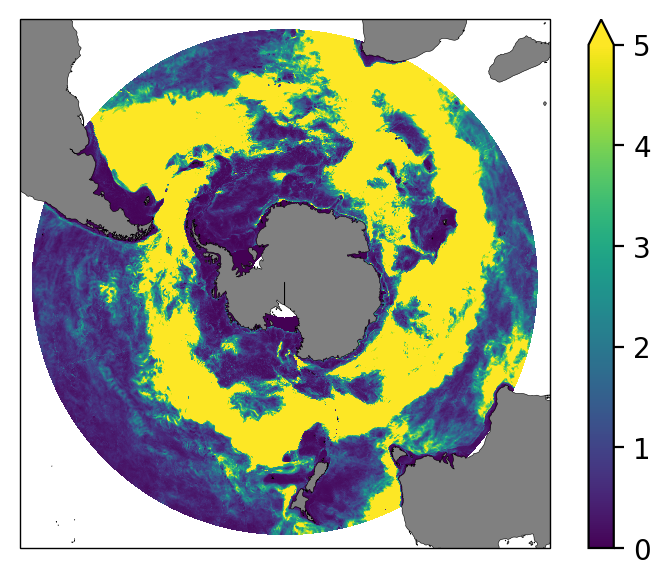

In [30]:
fig = plt.figure(figsize=(5, 3.5),dpi=100)

ax = fig.add_subplot(1, 1, 1,projection= ccrs.SouthPolarStereo())

EKE_cc.plot(ax=ax,transform=ccrs.PlateCarree(), vmax=5);

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)

## Implementation of dask directly

Note: This example work but performance could be improved (it requires further debugging).

In [16]:
import netCDF4
import dask.array as da

In [17]:
@memory.cache
def calc_mke_dask(expt, n=72):

    #Identify files and paths for u and v.
    ncfiles=[str(f[0].ncfile_path)  for f in cc.querying._ncfiles_for_variable(expt, 'u', session) if 'ocean_daily_3d' in str(f[0].ncfile_path) ]
    u_ncfiles=ncfiles[-20:]
    
    ncfiles=[str(f[0].ncfile_path)  for f in cc.querying._ncfiles_for_variable(expt, 'v', session) if 'ocean_daily_3d' in str(f[0].ncfile_path) ]
    v_ncfiles=ncfiles[-20:]

    #Construct datasets
    u_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['u'],
            chunks=(1, 7, 300, 400)) for ncfile in u_ncfiles]
    u = da.concatenate(u_dataarrays, axis=0)

    v_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['v'],
            chunks=(1, 7, 300, 400)) for ncfile in v_ncfiles]
    v = da.concatenate(v_dataarrays, axis=0)

    #Make sure to mask fillvalue.
    u[u==netCDF4.Dataset(u_ncfiles[0], 'r')['u'].getncattr('_FillValue')]=np.nan
    v[v==netCDF4.Dataset(v_ncfiles[0], 'r')['v'].getncattr('_FillValue')]=np.nan
    
    #Compute averages with nan.
    u_mean = da.nanmean(u, axis=0)
    v_mean = da.nanmean(v, axis=0)
    
    # Create temporal xarray structure
    temp = cc.querying.getvar(expt, 'u', session,ncfile='ocean_daily_3d_u_%.nc', start_time = start_time).isel(time=-1)
    
    # Define dz for intergral on depth.
    dz = np.gradient(temp.st_ocean)[:, np.newaxis, np.newaxis]
    
    #Compute MKE
    MKEdensity = 0.5 * (u_mean**2 + v_mean**2)
    MKE_int = da.nansum(MKEdensity*dz, axis=0)
    
    MKE = ccd.compute_by_block(MKE_int)
    
    #Store files
    template = temp.sum('st_ocean')
    result = xr.zeros_like(template).compute()
    result[:] = MKE
    result.name = 'MKE'
    
    return result

In [18]:
%%time
MKE_v2 = calc_mke_dask(expt, n=24)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_u_01.nc', 'ocean_daily_3d_u_04.nc', 'ocean_daily_3d_u_07.nc', 'ocean.nc', 'ocean_daily_3d_u_02.nc', 'ocean_daily_3d_u_08.nc', 'ocean_daily_3d_u_10.nc', 'ocean_daily_3d_u_11.nc', 'ocean_daily_3d_u_05.nc', 'ocean_daily_3d_u_09.nc', 'ocean_daily_3d_u_03.nc', 'ocean_daily_3d_u_12.nc', 'ocean_daily_3d_u_06.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_v_02.nc', 'ocean.nc', 'ocean_daily_3d_v_05.nc', 'ocean_daily_3d_v_09.nc', 'ocean_daily_3d

CPU times: user 13min 16s, sys: 47.4 s, total: 14min 3s
Wall time: 18min 8s


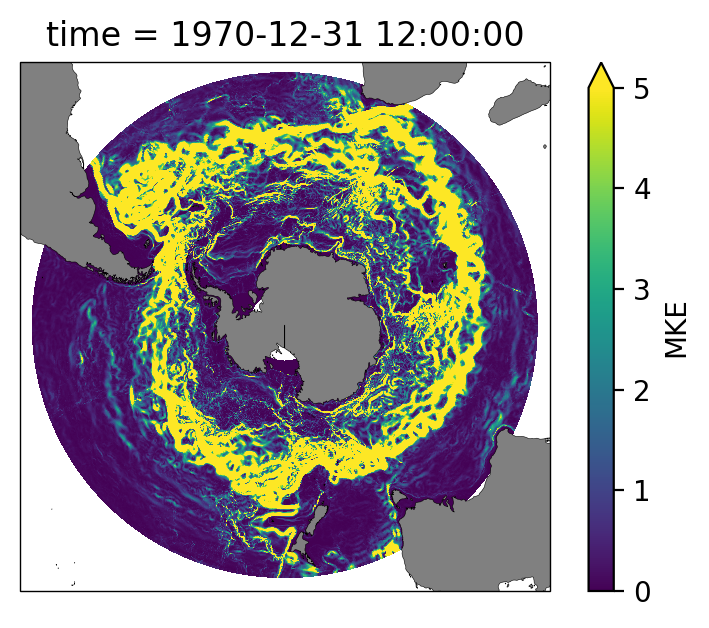

In [19]:
fig = plt.figure(figsize=(5, 3.5),dpi=100)

ax = fig.add_subplot(1, 1, 1,projection= ccrs.SouthPolarStereo())

MKE_v2.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=5);

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)

In [20]:
@memory.cache
def calc_eke_dask(expt, n=72):

    ncfiles=[str(f[0].ncfile_path)  for f in cc.querying._ncfiles_for_variable(expt, 'u', session) if 'ocean_daily_3d' in str(f[0].ncfile_path) ]
    u_ncfiles=ncfiles[-20:]
    
    ncfiles=[str(f[0].ncfile_path)  for f in cc.querying._ncfiles_for_variable(expt, 'v', session) if 'ocean_daily_3d' in str(f[0].ncfile_path) ]
    v_ncfiles=ncfiles[-20:]

    u_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['u'],
            chunks=(1, 7, 300, 400)) for ncfile in u_ncfiles]
    u = da.concatenate(u_dataarrays, axis=0)

    v_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['v'],
            chunks=(1, 7, 300, 400)) for ncfile in v_ncfiles]
    v = da.concatenate(v_dataarrays, axis=0)
    
    u[u==netCDF4.Dataset(u_ncfiles[0], 'r')['u'].getncattr('_FillValue')]=np.nan
    v[v==netCDF4.Dataset(v_ncfiles[0], 'r')['v'].getncattr('_FillValue')]=np.nan

    u_mean = da.nanmean(u,axis=0)
    v_mean = da.nanmean(v,axis=0)
    
    # Create temporal xarray structure
    temp = cc.querying.getvar(expt,'u',session,ncfile='ocean_daily_3d_u_%.nc',start_time = start_time).isel(time=-1)
    
    # Define dz for intergral on depth.
    dz = np.gradient(temp.st_ocean)[:, np.newaxis, np.newaxis]
    
    u_transient = u - u_mean
    v_transient = v - v_mean

    EKEdensity = 0.5 * (u_transient**2 + v_transient**2)
    EKEmeantime = da.nanmean(EKEdensity,axis=0)
    EKEsum = da.nansum(EKEmeantime*dz,axis=0)
    
    EKE_dask = ccd.compute_by_block(EKEsum)
    
    template = temp.sum('st_ocean')
    result = xr.zeros_like(template).compute()
    result[:] = EKE_dask
    result.name = 'EKE'
    
    return result

In [21]:
%%time
EKE_v2 = calc_eke_dask(expt, n=24)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_u_01.nc', 'ocean_daily_3d_u_04.nc', 'ocean_daily_3d_u_07.nc', 'ocean.nc', 'ocean_daily_3d_u_02.nc', 'ocean_daily_3d_u_08.nc', 'ocean_daily_3d_u_10.nc', 'ocean_daily_3d_u_11.nc', 'ocean_daily_3d_u_05.nc', 'ocean_daily_3d_u_09.nc', 'ocean_daily_3d_u_03.nc', 'ocean_daily_3d_u_12.nc', 'ocean_daily_3d_u_06.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_v_02.nc', 'ocean.nc', 'ocean_daily_3d_v_05.nc', 'ocean_daily_3d_v_09.nc', 'ocean_daily_3d

CPU times: user 46min 10s, sys: 4min 12s, total: 50min 22s
Wall time: 1h 57min 58s


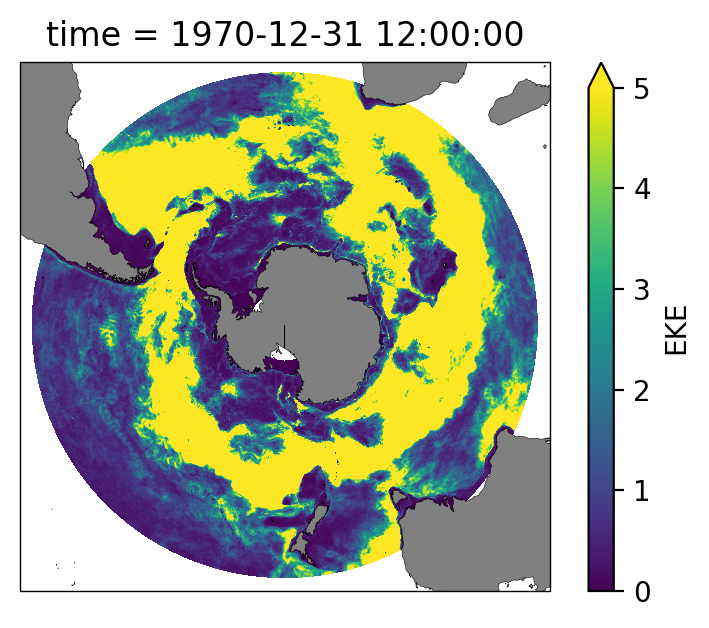

In [22]:
fig = plt.figure(figsize=(5, 3.5),dpi=100)

ax = fig.add_subplot(1, 1, 1,projection= ccrs.SouthPolarStereo())

EKE_v2.plot(ax=ax,transform=ccrs.PlateCarree(),vmax=5);

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)

Note the walltime of the CC implementation takes between 14min 23s to 1 hour 2min for MKE and EKE respectively to analyze 396 days of data. Meanwhile, the dask-netCDF4 implementation used 18min 8s and 1 hour 57min to analyze 610 days of data. Overall, the CC implementation takes between 0.10 to 0.45 s/day, while the dask implementation corresponds to 0.08 to 0.56s/day. Both results are comparable, however the dask implementation is more reliable when handleling larger datasets (i.e daily climatology).